In [1]:
from transformers import DetrFeatureExtractor
import PIL.Image

#数据预处理工具
feature_extractor = DetrFeatureExtractor.from_pretrained(
    'facebook/detr-resnet-50', max_size=107.9256 + 60.8841 * 0.2)

print(feature_extractor)

#试算
feature_extractor(
    images=[
        PIL.Image.new('RGB', (100, 100), 'white'),
        PIL.Image.new('RGB', (200, 100), 'white')
    ],
    annotations=[{
        'image_id':
        0,
        'annotations': [{
            'category_id': 0,
            'area': 1,
            'bbox': [1, 2, 3, 4],
        }, {
            'category_id': 0,
            'area': 1,
            'bbox': [1, 2, 3, 4],
        }]
    }, {
        'image_id':
        0,
        'annotations': [{
            'category_id': 0,
            'area': 1,
            'bbox': [1, 2, 3, 4],
        }]
    }],
    return_tensors='pt',
)

DetrFeatureExtractor {
  "do_normalize": true,
  "do_resize": true,
  "feature_extractor_type": "DetrFeatureExtractor",
  "format": "coco_detection",
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "max_size": 120.10242,
  "size": 800
}



{'pixel_values': tensor([[[[2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          ...,
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489]],

         [[2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          ...,
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286]],

         [[2.6400, 2.6400, 2.6400,  ..., 2.6400, 2.6400, 2.6400],
          [2.6400, 2.6400, 2.6400,  ..., 2.6400, 2.6400, 2.6400],
          [2.6400, 2.6400

In [2]:
from datasets import load_dataset, load_from_disk, concatenate_datasets

#dataset = load_dataset(path='svhn', name='full_numbers')
#dataset.save_to_disk('datas/svhn/full_numbers')
dataset = load_from_disk('datas/svhn/full_numbers')

#合并
dataset = concatenate_datasets(
    [dataset['train'], dataset['test'], dataset['extra']])


#过滤
def f(data):
    #统计得出的数据,std乘以一个系数以控制差异度
    w_mean = 107.9256
    w_std = 60.8841 * 0.2

    h_mean = 63.2230
    h_std = 32.3928 * 0.2

    r_mean = 1.8266
    r_std = 0.5134 * 0.4

    results = []
    for image in data['image']:
        w, h = image.size
        r = w / h

        if not w_mean - w_std <= w <= w_mean + w_std:
            results.append(False)
            continue

        if not h_mean - h_std <= h <= h_mean + h_std:
            results.append(False)
            continue

        if not r_mean - r_std <= r <= r_mean + r_std:
            results.append(False)
            continue

        results.append(True)

    return results


dataset = dataset.filter(f, batched=True, num_proc=4, batch_size=1000)

#重新切分
dataset = dataset.train_test_split(test_size=0.01, seed=0)

dataset

Loading cached processed dataset at datas/svhn/full_numbers/train/cache-b5d1f93faba660a3_00000_of_00004.arrow


Loading cached processed dataset at datas/svhn/full_numbers/extra/cache-b5d1f93faba660a3_00001_of_00004.arrow


Loading cached processed dataset at datas/svhn/full_numbers/extra/cache-b5d1f93faba660a3_00002_of_00004.arrow


Loading cached processed dataset at datas/svhn/full_numbers/extra/cache-b5d1f93faba660a3_00003_of_00004.arrow
Loading cached split indices for dataset at datas/svhn/full_numbers/train/cache-e987762ebef60eb1.arrow and datas/svhn/full_numbers/train/cache-0b31e8a9fc087eba.arrow


DatasetDict({
    train: Dataset({
        features: ['image', 'digits'],
        num_rows: 6646
    })
    test: Dataset({
        features: ['image', 'digits'],
        num_rows: 68
    })
})

In [3]:
import torch


#数据整理函数
def collate_fn(data):
    images = [i['image'] for i in data]
    digits = [i['digits'] for i in data]

    #把数据格式转换成coco格式,这是个非常蛋疼的格式
    annotations = []
    for digit in digits:
        i = {'image_id': 1, 'annotations': []}
        for label, bbox in zip(digit['label'], digit['bbox']):
            i['annotations'].append({
                'category_id': label,
                'area': 1,
                'bbox': bbox
            })
        annotations.append(i)

    #编码
    data = feature_extractor(images=images,
                             annotations=annotations,
                             return_tensors='pt')

    for label in data['labels']:
        del label['image_id']
        del label['area']
        del label['iscrowd']

    return data


loader = torch.utils.data.DataLoader(
    dataset=dataset['train'],
    batch_size=8,
    collate_fn=collate_fn,
    shuffle=True,
    drop_last=True,
)

for i, data in enumerate(loader):
    break

print(len(loader)), data

830


(None,
 {'pixel_values': tensor([[[[-0.0629, -0.0458, -0.0287,  ..., -0.1143,  0.0000,  0.0000],
           [-0.0972, -0.0801, -0.0801,  ..., -0.1999,  0.0000,  0.0000],
           [-0.1314, -0.1314, -0.1314,  ..., -0.2513,  0.0000,  0.0000],
           ...,
           [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
           [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
           [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
 
          [[ 0.2227,  0.2402,  0.2577,  ...,  0.2052,  0.0000,  0.0000],
           [ 0.2577,  0.2752,  0.2752,  ...,  0.2227,  0.0000,  0.0000],
           [ 0.2752,  0.2752,  0.2752,  ...,  0.2402,  0.0000,  0.0000],
           ...,
           [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
           [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
           [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
 
          [[ 0.5659,  0.5834,  0.6182,  ...,  0.5311,  0.0000,

In [4]:
from transformers import DetrForObjectDetection, DetrModel
from transformers.models.detr.modeling_detr import DetrLoss, DetrHungarianMatcher, DetrObjectDetectionOutput

#加载模型
#model = DetrForObjectDetection.from_pretrained('facebook/detr-resnet-50',num_labels=10,ignore_mismatched_sizes=True)


#定义下游任务模型
class Model(torch.nn.Module):

    def __init__(self):
        super().__init__()
        self.pretrained = DetrModel.from_pretrained('facebook/detr-resnet-50')

        #分类网络,在物品数量上+1,因为多一个背景类
        self.fc_label = torch.nn.Linear(256, 11)

        #定位网络
        self.fc_bbox = torch.nn.Sequential(
            torch.nn.Linear(256, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 4),
            torch.nn.Sigmoid(),
        )

        #加载预训练模型的参数
        parameters = DetrForObjectDetection.from_pretrained(
            'facebook/detr-resnet-50',
            num_labels=10,
            ignore_mismatched_sizes=True)

        self.fc_label.load_state_dict(
            parameters.class_labels_classifier.state_dict())

        self.fc_bbox[0].load_state_dict(
            parameters.bbox_predictor.layers[0].state_dict())
        self.fc_bbox[2].load_state_dict(
            parameters.bbox_predictor.layers[1].state_dict())
        self.fc_bbox[4].load_state_dict(
            parameters.bbox_predictor.layers[2].state_dict())

        #Detr的loss函数
        self.criterion = DetrLoss(matcher=DetrHungarianMatcher(class_cost=1,
                                                               bbox_cost=5,
                                                               giou_cost=2),
                                  num_classes=10,
                                  eos_coef=0.1,
                                  losses=['labels', 'boxes', 'cardinality'])

    def forward(self, pixel_values, pixel_mask, labels=None):
        logits = self.pretrained(pixel_values=pixel_values,
                                 pixel_mask=pixel_mask)

        #[b, 100, 256]
        logits = logits.last_hidden_state

        #[b, 100, 256] -> [b, 100, 2]
        out_label = self.fc_label(logits)
        #[b, 100, 256] -> [b, 100, 4]
        out_bbox = self.fc_bbox(logits)

        loss = None
        if labels:
            #计算loss
            loss = self.criterion({
                'logits': out_label,
                'pred_boxes': out_bbox
            }, labels)

            #loss加权
            loss['loss_ce'] *= 1
            loss['loss_bbox'] *= 5
            loss['loss_giou'] *= 2

            #求和
            loss = sum(loss.values())

        #return {'loss': loss, 'logits': out_label, 'pred_boxes': out_bbox}
        #其实就是个数据的载体,没干什么特别的事情,因为后面有点操作,所以不能直接用字典
        return DetrObjectDetectionOutput(loss=loss,
                                         logits=out_label,
                                         pred_boxes=out_bbox)


model = Model()

#统计参数量
print(sum(i.numel() for i in model.parameters()) / 10000)

with torch.no_grad():
    out = model(**data)

out['loss'], out.keys()

Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrModel: ['bbox_predictor.layers.1.bias', 'bbox_predictor.layers.0.bias', 'bbox_predictor.layers.2.bias', 'bbox_predictor.layers.1.weight', 'bbox_predictor.layers.2.weight', 'bbox_predictor.layers.0.weight', 'class_labels_classifier.weight', 'class_labels_classifier.bias']
- This IS expected if you are initializing DetrModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DetrForObjectDetection were not initialized from the model checkpoint at facebook/detr-resnet-50 and are newly initialized because the shapes did not match:
- 

4151.1631


(tensor(103.4795), odict_keys(['loss', 'logits', 'pred_boxes']))

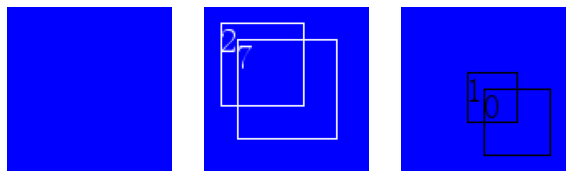

In [5]:
from matplotlib import pyplot as plt
%matplotlib inline
import PIL.ImageDraw
import PIL.ImageFont


def show(image, target, predict):
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.axis('off')

    copy = image.copy()
    draw = PIL.ImageDraw.Draw(copy)
    font = PIL.ImageFont.truetype('datas/simsun.ttc', 20)

    for label, bbox in zip(target['label'], target['bbox']):
        bbox[2] += bbox[0]
        bbox[3] += bbox[1]
        draw.rectangle(xy=bbox, outline='white', width=1)
        draw.text(xy=bbox[:2], text=str(label), fill='white', font=font)

    plt.subplot(1, 3, 2)
    plt.imshow(copy)
    plt.axis('off')

    copy = image.copy()
    draw = PIL.ImageDraw.Draw(copy)

    for i in predict:
        draw.rectangle(xy=i['box'], outline='black', width=1)
        draw.text(xy=i['box'][:2],
                  text=str(i['label']),
                  fill='black',
                  font=font)

    plt.subplot(1, 3, 3)
    plt.imshow(copy)
    plt.axis('off')
    plt.show()


target = {'bbox': [[10, 10, 50, 50], [20, 20, 60, 60]], 'label': [2, 7]}

predict = [{
    'label': 0,
    'box': [50, 50, 90, 90]
}, {
    'label': 1,
    'box': [40, 40, 70, 70]
}]

show(PIL.Image.new('RGB', (100, 100), 'blue'), target, predict)

In [6]:
def test():
    dataset['test'] = dataset['test'].shuffle()

    for i in range(10):
        image = dataset['test'][i]['image']
        target = dataset['test'][i]['digits']

        data = feature_extractor(images=image, return_tensors='pt')
        with torch.no_grad():
            out = model(**data)

        #取出图片的原始尺寸,交换长和宽的位置
        target_sizes = torch.LongTensor([image.size[1],
                                         image.size[0]]).unsqueeze(dim=0)

        #把预测的结果缩放到原始图片的尺寸,并计算出分数和label
        out = feature_extractor.post_process(out, target_sizes=target_sizes)[0]

        predict = []
        for j in range(len(out['scores'])):
            if out['scores'][j] < 0.5:
                continue

            predict.append({
                'label': out['labels'][j].item(),
                'box': out['boxes'][j].tolist(),
            })

        print(i)
        show(image, target, predict)


#test()

In [7]:
from transformers import AdamW
from transformers.optimization import get_scheduler


#训练
def train():
    global model
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = model.to(device)

    optimizer = AdamW(model.parameters(),
                      lr=2e-5,
                      betas=(0.9, 0.999),
                      eps=1e-8)
    scheduler = get_scheduler(name='linear',
                              num_warmup_steps=0,
                              num_training_steps=len(loader) * 150,
                              optimizer=optimizer)

    model.train()
    for epoch in range(150):
        for i, data in enumerate(loader):
            #设备
            data['pixel_values'] = data['pixel_values'].to(device)
            data['pixel_mask'] = data['pixel_mask'].to(device)
            for label in data['labels']:
                for k in label.keys():
                    label[k] = label[k].to(device)

            out = model(**data)
            loss = out['loss']

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            optimizer.step()
            scheduler.step()

            optimizer.zero_grad()
            model.zero_grad()

            if i % 200 == 0:
                lr = optimizer.state_dict()['param_groups'][0]['lr']
                print(epoch, i, loss.item(), lr)

    model = model.cpu()
    torch.save(model, 'models/12.目标侦测.model')

#train()

0


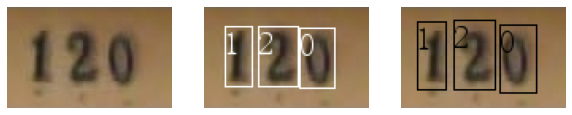

1


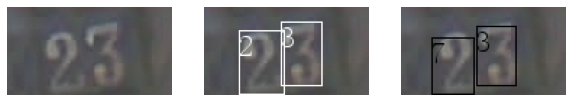

2


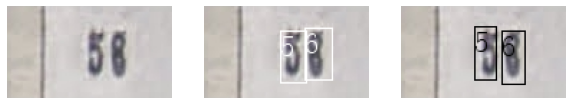

3


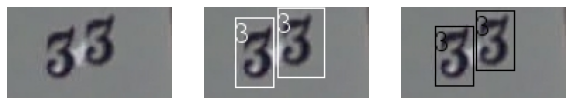

4


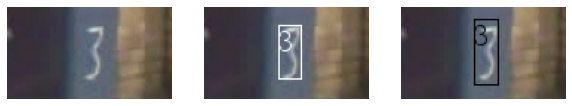

5


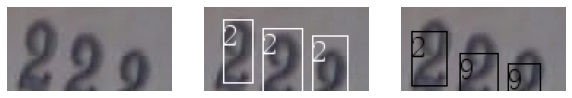

6


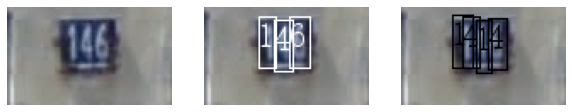

7


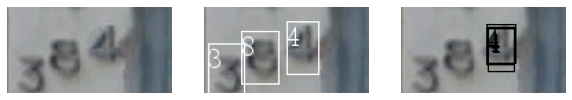

8


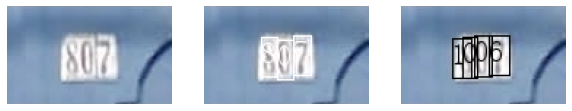

9


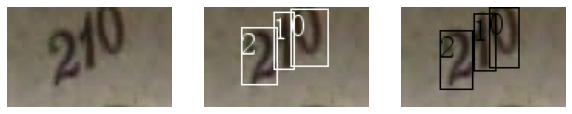

In [8]:
model = torch.load('models/12.目标侦测.model')

test()